# Front page heatmap

If we view the front page of each newspaper as an MxN matrix, we can assign each pixel an intensity P based off the font size of the character at that location. Averaging the intensity across all newspapers will generate the "average importance" of a particular location on a front page for all newspapers of that size.

* We'll first group newspapers into particular sizes
* We'll smooth the output using a density-based heatmap

In [1]:
import pandas as pd

df = pd.read_sql_table('frontpage_texts', 'postgres:///frontpages')

In [2]:
df.head()

,text,fontface,fontsize,bbox_left,bbox_bottom,bbox_right,bbox_top,bbox_area,avg_character_area,percent_of_page,page,page_width,page_height,page_area,date,day_of_week,weekend,slug,id
0,CHEYENNE – Education and \nunderstanding are c...,UYJQTF+Dutch811BT-RomanD,11.894,355.199,565.665,495.693,814.413,34947.601512,53.988159,0.030769,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146016
1,For more information\n,IGKWHD+GriffithGothicCond-Ultra,18.224,508.720,892.167,635.040,910.391,2302.055680,120.001395,0.002027,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146017
2,To learn more about the courthouse \nexpansion...,HCVQTF+GriffithGothic-Bold,9.758,508.720,825.022,637.342,885.185,7738.285386,35.217527,0.006813,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146018
3,"There, you can read descriptions of all \n44 p...",HCVQTF+GriffithGothic-Bold,9.758,508.720,798.859,637.929,818.698,2563.377351,33.936823,0.002257,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146019
4,raising $18 million to provide ad-\nditional s...,UYJQTF+Dutch811BT-RomanD,11.894,502.718,565.874,641.321,787.481,30715.395021,55.198782,0.027043,1,788.76,1440.0,1135814.4,2017-04-09,6,True,WY_WTE,146020


First, let's discover how many unique layouts there are for newspapers, and whether there is only one size per newspaper.

In [3]:
len(df.groupby(['page_width', 'page_height']).indices)

336

There may be subtle pixel-level differences that may be ignored. Let's round all values to the nearest pixel.

In [4]:
df['page_width_round'] = df['page_width'].apply(int)
df['page_height_round'] = df['page_height'].apply(int)

len(df.groupby(['page_width_round', 'page_height_round']).indices)

318

To the nearest 10 pixels?

In [5]:
df['page_width_round_10'] = df['page_width'].apply(lambda w: int(w/10)*10)
df['page_height_round_10'] = df['page_height'].apply(lambda w: int(w/10)*10)

print('''Number of unique dimensions: {}

Top dimensions:
{}'''.format(
    len(df.groupby(['page_width_round_10', 'page_height_round_10']).slug.nunique()),
    df.groupby(['page_width_round_10', 'page_height_round_10']).slug.nunique().sort_values(ascending=False)[:10]
))

Number of unique dimensions: 260

Top dimensions:
page_width_round_10  page_height_round_10
790                  1580                    34
                     1510                    30
                     1540                    19
                     1630                    17
                     1220                    12
                     1600                    12
                     1530                    11
                     1620                     9
800                  1070                     8
820                  1580                     7
Name: slug, dtype: int64


Perhaps it's good enough to grab the 34 newspapers in the 790x1580 categories for now.

What are they?

In [6]:
newspapers = pd.read_sql_table('newspapers', 'postgres:///frontpages')

In [7]:
WIDTH = 790
HEIGHT = 1580

df_at_size = df[(df.page_width_round_10 == WIDTH) & (df.page_height_round_10 == HEIGHT)]

print('Number of days for which we data for each newspaper')
pd.merge(newspapers, df_at_size.groupby('slug').date.nunique().reset_index(), on='slug').sort_values('date', ascending=False)

Number of days for which we data for each newspaper


,city,country,latitude,longitude,slug,state,title,website,date
14,Lowell,USA,42.645889,-71.312843,MA_TS,MA,The Sun,http://www.lowellsun.com,9
26,Corpus Christi,USA,27.798986,-97.395905,TX_CCCT,TX,Corpus Christi Caller-Times,http://www.caller.com,9
25,Nashville,USA,36.157280,-86.786865,TN_TT,TN,The Tennessean,http://www.tennessean.com,9
23,Clarksville,USA,36.526154,-87.357780,TN_LC,TN,The Leaf-Chronicle,http://www.theleafchronicle.com,9
6,Crystal River,USA,28.886683,-82.539505,FL_CCC,FL,Citrus County Chronicle,http://chronicleonline.com,9
8,Rome,USA,34.253719,-85.166397,GA_RNT,GA,Rome News-Tribune,http://www.romenews-tribune.com,9
9,Bedford,USA,38.861179,-86.481514,IN_TM,IN,Times-Mail,http://www.tmnews.com,9
16,Rochester,USA,43.154022,-77.612679,NY_RDC,NY,Rochester Democrat and Chronicle,http://www.democratandchronicle.com,9
13,Gloucester,USA,42.618275,-70.676605,MA_GDT,MA,The Gloucester Daily Times,http://www.gloucestertimes.com,8
24,Murfreesboro,USA,35.844398,-86.394341,TN_DNJ,TN,The Daily News Journal,http://www.dnj.com,8


We're interested in the average character size at every pixel on these newspapers. Let's go about constructing the matrix for one of them.

In [8]:
one_paper = df_at_size[(df_at_size.slug=='NY_RDC') & (df_at_size.date == df_at_size.date.max())]

print('''The Rochester Democrat and Chronicle has {} entries in the database across {} days.

On the latest day, it has {} text fields.
'''.format(
    df_at_size[df_at_size.slug == 'NY_RDC'].shape[0],
    df_at_size[df_at_size.slug == 'NY_RDC'].date.nunique(),
    one_paper.shape[0]
))

The Rochester Democrat and Chronicle has 292 entries in the database across 9 days.

On the latest day, it has 32 text fields.



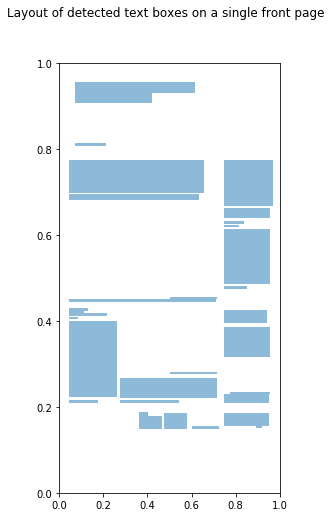

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

plt.figure(figsize=(WIDTH/200, HEIGHT/200))
currentAxis = plt.gca()

for i, row in one_paper.iterrows():
    left = row.bbox_left / row.page_width
    right = row.bbox_right / row.page_width
    top = row.bbox_top / row.page_height
    bottom = row.bbox_bottom / row.page_height
    
    currentAxis.add_patch(Rectangle((left, bottom), right-left, top-bottom,alpha=0.5))
    
plt.suptitle('Layout of detected text boxes on a single front page')
plt.show()

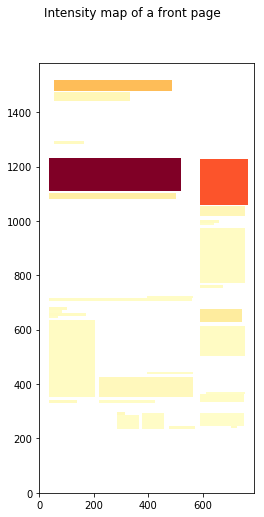

In [76]:
import numpy as np

def make_intensity_grid(paper, verbose=False):
    intensity_grid = np.zeros((HEIGHT, WIDTH))

    for i, row in paper.iterrows():
        left = int(row.bbox_left)
        right = int(row.bbox_right)
        top = int(row.bbox_top)
        bottom = int(row.bbox_bottom)

        if np.count_nonzero(intensity_grid[bottom:top, left:right]) > 0:
            if verbose:
                print('Warning: overlapping bounding box with', bottom, top, left, right)
        intensity_grid[bottom:top, left:right] = row.avg_character_area
    
    return intensity_grid

def plot_intensity(intensity, title, scale=100):
    height, width = intensity.shape
    fig = plt.figure(figsize=(height/scale, width/scale))
    ax = plt.gca()

    cmap = plt.get_cmap('YlOrRd')
    cmap.set_under(color='white')

    fig.suptitle(title)
    plt.imshow(intensity, cmap=cmap, extent=[0, width, 0, height], origin='lower', vmin=0.1)
    plt.close()
    return fig
    
intensity_grid = make_intensity_grid(one_paper)
plot_intensity(intensity_grid, 'Intensity map of a front page')

In [11]:
intensities = []
for i, ((date, slug), paper) in enumerate(df_at_size.groupby(['date', 'slug'])):
    if i % 50 == 0:
        print('.', end='')
    intensities.append(make_intensity_grid(paper))

.....

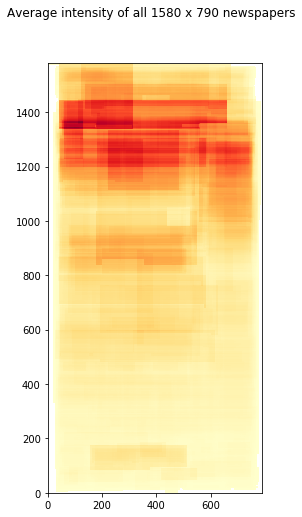

In [12]:
avg_intensity = sum(intensities) / len(intensities)
plot_intensity(avg_intensity, 'Average intensity of all {} x {} newspapers'.format(HEIGHT, WIDTH))

# Considering all newspapers of the same aspect ratio

We had to subset the newspapers quite significantly in order to find a bunch with the same exact height and width. Instead, let's find the newspapers with the same aspect ratio, and consider them after scaling.

In [13]:
df['aspect_ratio'] = df['page_width_round_10'] / df['page_height_round_10']

print('''Out of {} newspapers, there are {} unique aspect ratios.

The top ones are:
{}'''.format(
    df.slug.nunique(),
    df.groupby('slug').aspect_ratio.first().nunique(),
    df.groupby('slug').aspect_ratio.first().value_counts().head(5)
))

Out of 580 newspapers, there are 239 unique aspect ratios.

The top ones are:
0.500000    40
0.523179    30
0.512987    19
0.484663    17
0.493750    12
Name: aspect_ratio, dtype: int64


The top ones all look awfully close to 50-50. Let's round to the tenth place.

In [15]:
import math

df['aspect_ratio'] = np.round(df['page_width_round_10'] / df['page_height_round_10'], decimals=1) 

print('''This time, there are {} unique aspect ratios.

Top ones:
{}'''.format(
    df.groupby('slug').aspect_ratio.first().nunique(),
    df.groupby('slug').aspect_ratio.first().value_counts()
))

This time, there are 8 unique aspect ratios.

Top ones:
0.5    349
0.7     97
0.6     83
0.8     27
0.9     15
0.4      4
1.0      4
1.4      1
Name: aspect_ratio, dtype: int64


Over half of the newspapers have roughly a 1:2 aspect ratio. Let's scale them and push the errors toward the right and bottom margins.

In [16]:
smallest_width = df[df.aspect_ratio == 0.5].page_width_round_10.min()
smallest_height = df[df.aspect_ratio == 0.5].page_height_round_10.min()
print('''The easiest way would be to scale down to the smallest dimensions.

{} x {}'''.format(
    smallest_width,
    smallest_height
))

The easiest way would be to scale down to the smallest dimensions.

680 x 1420


In [71]:
from scipy.misc import imresize

intensities = []
for i, ((date, slug), paper) in enumerate(df[df.aspect_ratio == 0.5].groupby(['date', 'slug'])):
    if i % 50 == 0:
        print('.', end='')
    intensities.append(imresize(make_intensity_grid(paper), (smallest_height, smallest_width)))

............................................

In [72]:
count = len(intensities)
avg_intensity = sum([x / count for x in intensities])

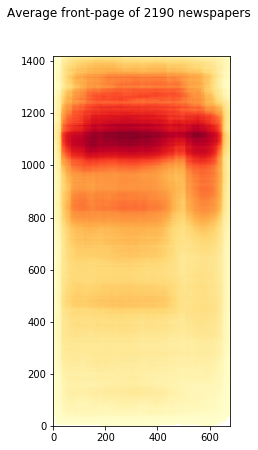

In [77]:
plot_intensity(avg_intensity, 'Average front-page of {} newspapers'.format(len(intensities)))